# Building a custom Executor in NVFlare

Now that we have our `DistOptController`, it's time to take care of the actual execution of the algorithm at the client level.
In this tutorial, we'll walk through how to build a custom executor on top of the NVFlare `Executor` for performing a Peer-to-Peer (P2P) distributed optimization algorithm.

## Overview
In NVFlare, an `Executor` is a client-side component that processes tasks received from the controller and executes them accordingly. In our P2P algorithm, the custom executor's main responsibilities are:

- Receiving the configuration from the server/controller.
- Communicating with its neighbors, sending and receiving messages.
- Running the algorithm, performing computations and coordinating with other clients.

We'll create a custom executor named `SyncAlgorithmExecutor` by subclassing the base `Executor` class provided by NVFlare.

> Note: Like the `Controller`, an `Executor` is also a subclass of `FLComponent`. 

To add some extra complexity, we'll focus on synchronous algorithms only, meaning that the clients will need to implement some sort of synchronization mechaniscm to execute iterations of the algorithm in a synchronous way. 
We'll call our executor `SyncAlgorithmExecutor`.

## Implementing the Executor

### More key components
Before we dive into the implementation, let's understand some key components and methods we'll use. This will help in comprehending how everything fits together. Beyond the `FLContext`, `Signal`, `Shareable` and `DXO` that we saw in the previous notebook, we'll make use of [aux channels](https://nvflare.readthedocs.io/en/2.5/apidocs/nvflare.private.aux_runner.html#nvflare.private.aux_runner.AuxRunner.send_aux_request) to send messages between clients. In particular we'll see two methods in use:
- [`send_aux_request`](https://nvflare.readthedocs.io/en/2.5/apidocs/nvflare.private.fed.client.client_engine_executor_spec.html#nvflare.private.fed.client.client_engine_executor_spec.ClientEngineExecutorSpec.send_aux_request): A method used to send auxiliary (non-primary) messages between clients (or between clients and server). It's part of the communication mechanism in NVFlare for client-to-client or client-to-server communication outside the main task flow. It requires to specify a list of `targets`, a `topic`, a `request` (a `Shareable` to send) and a `timeout` (i.e., the number of seconds to wait for replies).
- `register_aux_message_handler`: A method to be used used to register a callback function that handles auxiliary messages for a specific `topic`. This specifies how clients can respond to messages sent via `send_aux_request`. It requires two arguments: the `topic` to be handled, and a callable function to handle the message `message_handle_func`.

Notice that both methods are natively available to the `Executor` class.

Moreover, we'll use Python's `threading.Event` and `threading.Lock` to synchronize execution and ensure thread-safe access to shared resources.

### Implementing the `SyncAlgorithmExecutor`
For our purposes, we'll need our executor to be able to do a few things:
- Receive the configuration from the server/controller.
- Communicate with its neighbors and send/receive messages to/from them.
- Run the algorithm.

The primary method we need to implement is the `execute` method, which processes tasks received from the controller. This method takes the `task_name`, a `shareable` (data sent from the controller), the `fl_ctx` (federated learning context), and an `abort_signal`.

#### Basic Structure
Here's the basic structure of our executor:

```python
from nvflare.apis.executor import Executor
from nvflare.apis.fl_constant import ReturnCode
from nvflare.apis.fl_context import FLContext
from nvflare.apis.shareable import Shareable, make_reply
from nvflare.apis.signal import Signal


class SyncAlgorithmExecutor(Executor):

    def execute(
        self,
        task_name: str,
        shareable: Shareable,
        fl_ctx: FLContext,
        abort_signal: Signal,
    ):
        if task_name == "config":
            # TODO: receive and store config
            ...
            return make_reply(ReturnCode.OK)
        elif task_name == "run_algorithm":
            # TODO: run the algorithm
            return make_reply(ReturnCode.OK)
        else:
            self.log_warning(fl_ctx, f"Unknown task name: {task_name}")
            return make_reply(ReturnCode.TASK_UNKNOWN)
```
As mentioned, the `execute` method handles the execution of tasks based on the `task_name`. Remember, that, many times, when a controller sends a task, it waits to receive some response back - so, this method should also return a `Shareable` object, here created using `make_reply`, which includes a `ReturnCode` indicating the result of the execution.

#### Handling the `"config"` task

Let's focus on handling the `"config"` task first. We need to receive configuration data from the server and store it locally. We'll also initialize attributes to store the configuration and the neighbors' information.

```python
from nvflare.apis.dxo import from_shareable
from nvdo.types import LocalConfig, Neighbor


class SyncAlgorithmExecutor(Executor):
    def __init__(self):
        super().__init__()

        self.config = None
        self._weight = None
        self.neighbors: list[Neighbor] = []


    def execute(
        self,
        task_name: str,
        shareable: Shareable,
        fl_ctx: FLContext,
        abort_signal: Signal,
    ):
        if task_name == "config":
            # Receive and store config
            self.config = LocalConfig(**from_shareable(shareable).data)
            self.neighbors = self.config.neighbors

            # Compute local weight (this depends on the algorithm)
            self._weight = 1.0 - sum([n.weight for n in self.neighbors])

            return make_reply(ReturnCode.OK)

        elif task_name == "run_algorithm":
            # TODO: run the algorithm
            return make_reply(ReturnCode.OK)
        else:
            self.log_warning(fl_ctx, f"Unknown task name: {task_name}")
            return make_reply(ReturnCode.TASK_UNKNOWN)
```

Here, we're using a few additional components:
- `from_shareable`: Converts a `Shareable` back into a `DXO`. This is useful to easily extract the actual data payload from the shareable received from the server (in this case containing the configuration data dictionary).
- `LocalConfig`: A data structure we defined in the [introduction](../09.0_introduction/introduction.ipynb) to store the client's local configuration, including neighbors in a pythonic way.

#### Communication between clients

The previous step was relatively easy.
Now, we'll handle the more challenging part: enabling clients to communicate with each other. This involves:

- Sending messages to neighbors: Using `send_aux_request` to send messages to neighboring clients.
- Receiving messages from neighbors: Registering a callback function to handle incoming messages via `register_aux_message_handler`. We'll call the callback `_handle_neighbor_value` and the registration will be done in the `handle_event` method at start time (i.e., when receiving the `EventType.START_RUN` event). Other events can be handled in the same way if needed.
- Synchronizing execution: Using threading events and locks to coordinate the execution of the algorithm.
- Handling message formats: Implementing methods to serialize and deserialize messages (this is useful, for example, to send torch tensors). We'll add two methods, `_from_message` and `_to_message` to do that.

The main message exchange will be done in the `_exchange_values` function. Let's first look at the implementation and then we'll discuss it in detail.

```python
import threading
from abc import abstractmethod
from collections import defaultdict

from nvflare.apis.dxo import DXO, DataKind
from nvflare.apis.event_type import EventType
from nvflare.apis.signal import Signal


class SyncAlgorithmExecutor(Executor):
    def __init__(self, sync_timeout: int = 10):
        super().__init__()
        ... # other attributes

        self.neighbors_values = defaultdict(dict)

        # Threading primitives for synchronization
        self.sync_waiter = threading.Event()
        self.lock = threading.Lock()
        self.sync_timeout = sync_timeout


    def _exchange_values(self, fl_ctx: FLContext, value: any, iteration: int):
        engine = fl_ctx.get_engine()

        # Clear the event before starting the exchange
        self.sync_waiter.clear()

        # Send message to neighbors
        targets = [neighbor.id for neighbor in self.neighbors]
        dxo = DXO(
            data_kind=DataKind.METRICS,
            data={
                "value": self._to_message(value),
                "iteration": iteration,
            },
        )
        request = dxo.to_shareable()

        # Send auxiliary request to neighbors
        _ = engine.send_aux_request(
            targets=targets,
            topic="send_value",
            request=request,
            timeout=10,
            fl_ctx=fl_ctx,
        )

        # check if all neighbors sent their values
        if len(self.neighbors_values[iteration]) < len(self.neighbors):
            # if not, wait for them (up to self.sync_timeout seconds, defaults to 10)
            if not self.sync_waiter.wait(timeout=self.sync_timeout):
                self.system_panic("failed to receive values from all neighbors", fl_ctx)
                return

    def _handle_neighbor_value(
        self, topic: str, request: Shareable, fl_ctx: FLContext
    ) -> Shareable:
        # Retrieve the sender's identity from the request
        sender = request.get_peer_props()["__identity_name__"]
        data = from_shareable(request).data
        iteration = data["iteration"]

        with self.lock:
            # Store the received value
            self.neighbors_values[iteration][sender] = self._from_message(data["value"])
            # Check if all neighbor values have been received
            if len(self.neighbors_values[iteration]) >= len(self.neighbors):
                self.sync_waiter.set()  # Signal that we have all neighbor values
        return make_reply(ReturnCode.OK)

    def handle_event(self, event_type: str, fl_ctx: FLContext):
        if event_type == EventType.START_RUN:
            engine = fl_ctx.get_engine()
            # Register the message handler for receiving neighbor values
            engine.register_aux_message_handler(
                topic="send_value", message_handle_func=self._handle_neighbor_value
            )

    def _to_message(self, x):
        # Method to serialize the value for transmission
        return x

    def _from_message(self, x):
        # Method to deserialize the received value
        return x

```

Let's break down the key components of this implementation:
- Additional parameters:
    - `sync_waiter` (threading.Event): An event that allows threads to wait until it is set. Used here to synchronize the execution of the algorithm, making clients wait until all neighbor values have been received.
    - `lock` (threading.Lock): Ensures thread-safe access to shared data structures, such as neighbors_values.
    - `neighbors_values`: A dictionary that stores received values from neighbors, organized by iteration.
- `_exchange_values`: a custom method to handle the exchange of values with neighbors during each iteration. It follows the following process:
    1. Clears the `sync_waiter` event to ensure we're starting fresh.
    2. Sends an auxiliary request to each neighbor with the current value and iteration number.
    3. Checks if all neighbor values have been received; if not, waits for `sync_waiter` to be set or times out after 10 seconds.
    4. Handling Timeout: If the required neighbor values are not received within the timeout, the method calls `system_panic` to handle the error (usually logging and cleanup).
- `_handle_neighbor_value`: a custom callback to handle incoming messages from neighbors containing their values. It works by:
    1. Extracting the sender's identity and the data from the request.
    2. Storing the received value in `neighbors_values` under the appropriate iteration.
    3. Checking if all neighbor values for the iteration have been received; if so, sets `sync_waiter` to release any waiting threads.
    4. Thread Safety: Uses a `lock` to ensure that the update to `neighbors_values` and the check is atomic.
- `handle_event`: implement the `handle_event` of the base `Executor` to handle events sent by the engine. In this case. when `EventType.START_RUN` (i.e. when the run )starts, we register the auxiliary message handler for receiving neighbor values.
- `_to_message` and `_from_message`: custom placeholder methods for serializing and deserializing the message content. In subclasses, you might need to override these methods to handle complex data structures or use specific serialization formats (e.g., converting tensors to and from bytes).


> Notice that `neighbors_values` needs to maintain a dictionary of received values per iteration. This is because, different parts of a network may be at different iterations of the algorithm (plus or minus 1 at most) - this means that I could receive a message from a neighbor valid for iteration `t+1` when I'm still at iteration `t`. Since that message won't be sent again, I need to store it. **To avoid the `neighbors_values` to grow indefinitely, we'll delete its content at iteration `t` after having consumed its values and moving to the next iteration in the algorithm**. This can be done by `del self.neighbors_values[iteration]` after we're done with an iteration.

#### Running the algorithm

Now that we have a way to store the configuration and exchange messages with neighbors, we can implement the algorithmic part. For this `SyncAlgorithmExecutor`, we'll define an abstract `run_algorithm` method to be overridden by subclasses implementing specific algorithms.

```python
from abc import ABC, abstractmethod

class SyncAlgorithmExecutor(Executor, ABC):
    ...

    @abstractmethod
    def run_algorithm(
        self, fl_ctx: FLContext, shareable: Shareable, abort_signal: Signal
    ):
        """Executes the algorithm. Must be overridden by subclasses."""
        pass

    def execute(
        self,
        task_name: str,
        shareable: Shareable,
        fl_ctx: FLContext,
        abort_signal: Signal,
    ):
        if task_name == "config":
            # Receive topology from the server
            self.config = LocalConfig(**from_shareable(shareable).data)
            self.neighbors = self.config.neighbors
            self._weight = 1.0 - sum([n.weight for n in self.neighbors])
            return make_reply(ReturnCode.OK)

        elif task_name == "run_algorithm":
            # Run the algorithm
            if abort_signal.triggered:
                return make_reply(ReturnCode.TASK_ABORTED)

            self.run_algorithm(fl_ctx, shareable, abort_signal)
            return make_reply(ReturnCode.OK)

        else:
            self.log_warning(fl_ctx, f"Unknown task name: {task_name}")
            return make_reply(ReturnCode.TASK_UNKNOWN)
```

And that's all. The full implementation is in `nvflare/app_opt/p2p/executors/sync_executor.py` - note that the implementation of the `SyncAlgorithmExecutor` in `nvflare.app_opt.p2p` is a subclass of `BaseDistOptExecutor`, defined in `nvflare/app_opt/p2p/executors/base_dist_opt_executor.py`. It contains a few additional attributes (namely `self.id` and `self.client_name`) to identify the client, which are potentially useful in algorithms, and two additional methods `_pre_algorithm_run` and `_post_algorithm_run` to be overridden by each specific algorithm to execute some code before and after the algorithm execution, respectively.

### Example: Implementing the `ConsensusExecutor`

Now that we have built the main foundation with `SyncAlgorithmExecutor`, we can implement specific algorithms by subclassing it. Let's implement the consensus algorithm in the `ConsensusExecutor`.

#### Consensus Algorithm Overview
The consensus algorithm allows clients to reach agreement on a certain value through iterative averaging with their neighbors. Each client updates its value based on its own value and the values received from its neighbors, weighted accordingly. In formulas, each client $i$ maintains some local value $x_i^t$ and is connected to a subset of the other clients in the network, defined as the set of its neighbors $\mathcal{N}_i$.
The goal of all the clients is to reach consensus on their local values by communicating with their peers for a certain number of iterations $T$. 
In other terms, they want to cooperatively compute a weighted average of their initial values $x_i^0$.

The consensus algorithm works by having each client updating its local value as

$$x_i^{t+1} = \sum_{j\in\mathcal{N}_i}a_{ji}x_j^t$$

where $a_{ji}$ is the weight associated by client $i$ to client $j$ and $\sum_{j=1}^N a_{ji}=1$ for all $i$.

#### Implemntation

```python
import torch

class ConsensusExecutor(SyncAlgorithmExecutor):

    def __init__(
        self,
        initial_value: float | None = None,
    ):
        super().__init__()
        if initial_value is None:
            initial_value = random.random()
        self.initial_value = initial_value
        self.current_value = initial_value
        self.value_history = [self.current_value]

    def run_algorithm(self, fl_ctx, shareable, abort_signal):
        iterations = from_shareable(shareable).data["iterations"]

        for iteration in range(iterations):
            if abort_signal.triggered:
                self.log_info(fl_ctx, "Abort signal received. Exiting the algorithm loop.")
                break

            # 1. Exchange values with neighbors
            self._exchange_values(
                fl_ctx, value=self.current_value, iteration=iteration
            )

            # 2. Compute new value
            current_value = self.current_value * self._weight
            for neighbor in self.neighbors:
                neighbor_value = self.neighbors_values[iteration][neighbor.id]
                current_value += neighbor_value * neighbor.weight

            # 3. Store current value and history
            self.current_value = current_value
            self.value_history.append(self.current_value)

            # 4. Free memory that's no longer needed
            del self.neighbors_values[iteration]
        
        # save value_history
        torch.save(torch.tensor(self.value_history), "value_sequence.pt")

```

Let's explain the key parts:

- Initialization:
    - Sets an initial random value if none is provided.
    - Initializes `current_value` and `value_history` to keep track of the values over iterations.
- `run_algorithm`:
    - Retrieves the number of iterations from the shareable received.
    - For each iteration:
        1. Abort check: Checks if an abort signal has been triggered.
        2. Exchange values: Calls `_exchange_values` to send and receive values with neighbors.
        3. Compute new value by computing the weighted average of the current value and the received values from neighbors.
        4. Update state (`current_value`) and store value in `value_history`
        5. Cleanup: Deletes the neighbor values for the iteration to free up memory.
    - We let each client save their `value_history` to disk at the end of the algorithm

#### Running the consensus algorithm
Let's now show how to actually run the consensus algorithm we implemented through the NVFlare [job API](https://nvflare.readthedocs.io/en/2.5/programming_guide/fed_job_api.html).

For simplicity we generate a random network configuration with 5 clients and run the consensus algorithm for 50 iterations.

In [4]:
from nvflare.app_opt.p2p.utils.config_generator import generate_random_network
from nvflare.app_opt.p2p.types import Config
from rich import print

# generate random config
num_clients=5
network, adjacency_matrix = generate_random_network(num_clients=num_clients)
config = Config(network=network, extra={"iterations": 50})
print(config)

Config(
    network=Network(
        nodes=[
            Node(
                id='site-1',
                neighbors=[Neighbor(id='site-4', weight=0.25), Neighbor(id='site-5', weight=0.3333333432674408)]
            ),
            Node(id='site-2', neighbors=[Neighbor(id='site-4', weight=0.25)]),
            Node(id='site-3', neighbors=[Neighbor(id='site-4', weight=0.25)]),
            Node(
                id='site-4',
                neighbors=[
                    Neighbor(id='site-1', weight=0.25),
                    Neighbor(id='site-2', weight=0.25),
                    Neighbor(id='site-3', weight=0.25)
                ]
            ),
            Node(id='site-5', neighbors=[Neighbor(id='site-1', weight=0.3333333432674408)])
        ]
    ),
    extra={'iterations': 50}
)

Now we can use the job API to create a server running the `DistOptController` we implemented in the [previous section](../09.1_controllers/building_a_custom_controller.ipynb) and our new `ConsensusExecutor`. We'll use the NVFlare simulator to run the job.

In [6]:
from nvflare.job_config.api import FedJob
from nvflare.app_opt.p2p.executors import ConsensusExecutor
from nvflare.app_opt.p2p.controllers import DistOptController

# Create job
job = FedJob(name="consensus")

# send controller to server
controller = DistOptController(config=config)
job.to_server(controller)

# Add clients
for i in range(num_clients):
    executor = ConsensusExecutor() # the executor will be initialized with a random value
    job.to(executor, f"site-{i+1}")

# Run job via the NVFlare simulator
job.export_job("./tmp/job_configs")
job.simulator_run("./tmp/runs/consensus")

2025-02-04 17:55:17,373 - SimulatorRunner - INFO - Create the Simulator Server.
2025-02-04 17:55:17,374 - CoreCell - INFO - server: creating listener on tcp://0:54076
2025-02-04 17:55:17,399 - CoreCell - INFO - server: created backbone external listener for tcp://0:54076
2025-02-04 17:55:17,399 - ConnectorManager - INFO - 36037: Try start_listener Listener resources: {'secure': False, 'host': 'localhost'}
2025-02-04 17:55:17,400 - conn_manager - INFO - Connector [CH00002 PASSIVE tcp://0:15707] is starting
2025-02-04 17:55:17,901 - CoreCell - INFO - server: created backbone internal listener for tcp://localhost:15707
2025-02-04 17:55:17,901 - conn_manager - INFO - Connector [CH00001 PASSIVE tcp://0:54076] is starting
2025-02-04 17:55:17,902 - AuxRunner - INFO - registered aux handler for topic ObjectStreamer.Request
2025-02-04 17:55:17,902 - AuxRunner - INFO - registered aux handler for topic ObjectStreamer.Abort
2025-02-04 17:55:17,902 - Cell - INFO - Register blob CB for channel='aux_

Finally, we can inspect the `value_history` each client saved to check whether they actually converged to a consensus value

/var/folders/82/970ljrw529v0chx2svm8gwwr0000gp/T/ipykernel_35823/548183519.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  f"site-{i+1}": torch.load(f"tmp/runs/consensus

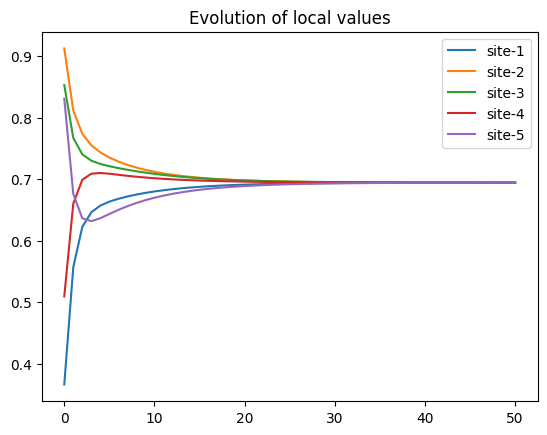

In [9]:
!pip install matplotlib torch
import torch
import matplotlib.pyplot as plt

# load history
history = {
    f"site-{i+1}": torch.load(f"tmp/runs/consensus/site-{i+1}/value_sequence.pt") for i in range(num_clients)
}

# plot results
plt.figure()
for i in range(num_clients):
    plt.plot(history[f"site-{i+1}"], label=f"site-{i+1}")
plt.legend()
plt.title("Evolution of local values")
plt.show()

## Conclusion
Our custom `SyncAlgorithmExecutor` and the example `ConsensusExecutor` demonstrate how to implement client-side logic for a P2P federated learning algorithm in NVFlare. The key steps involve:

- Handling tasks received from the controller.
- Exchanging messages with neighbors using auxiliary communication methods.
- Synchronizing execution using threading primitives.
- Implementing the algorithm logic in the run_algorithm method.

The full implementation of the `SyncAlgorithmExecutor` can be found in `nvflare/app_opt/p2p/executors/sync_executor.py`, and the `ConsensusExecutor` is implemented in `nvflare/app_opt/p2p/executors/consensus.py`.

Feel free to explore the `nvflare.app_opt.p2p` module to see how other algorithms are implemented and to build your own custom executors based on this template.